In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_error(sorted_data, x, p, is_int=False):
    if is_int:
        x = np.round(x)
    n = len(sorted_data)
    li = np.searchsorted(sorted_data, x, side="left")
    ri = np.searchsorted(sorted_data, x, side="right")
    qi = int(p * n)
    if ri < qi:
        return (qi-ri)*1.0/n
    elif li > qi:
        return (li-qi)*1.0/n
    else:
        return 0.0

In [3]:
colormap = {
    "cmoments": "C0",
    "tdigest": "C1",
    "yahoo": "C2",
    "spark_gk": "C3",
    "histogram": "C4",
    "sampling": "C5",
}
markers = {
    "cmoments": "x",
    "tdigest": "^",
    "yahoo": "s",
    "spark_gk": "+",
    "histogram": "D",
    "sampling": "o",
}
alg_display_name = {
    "cmoments": "M-Sketch",
    "tdigest": "T-Digest",
    "yahoo": "Merge12",
    "spark_gk": "GK",
    "histogram": "EW-Histogram",
    "sampling": "Sampling",
}

In [4]:
datasets = ["milan", "exponential", "hepmass", "retail", "occupancy"]
dataset_int = {
    "milan": False,
    "exponential": False,
    "hepmass": False,
    "retail": True,
    "occupancy": False
}

In [5]:
dataset_paths = {
    "milan": ("../../datasets/internet-mi-2013-11-01_09.csv","internet"),
    "exponential": ("../../datasets/exponential_10M.csv","x"),
    "hepmass": ("../../datasets/hepmass.csv","x"),
    "retail": ("../../datasets/retail_quantity_pos.csv","Quantity"),
    "occupancy": ("../../datasets/occupancy_2.csv","CO2")
}
sorted_vals = {}
for d in datasets:
    print(d)
    dpath, dcol = dataset_paths[d]
    df = pd.read_csv(dpath)
    sorted_vals[d] = np.sort(df[dcol])

milan
exponential
hepmass
retail
occupancy


In [6]:
result_path = "../finalresults/"
point_paths = {
    "milan": ["point_milan_m.csv", "point_milan.csv"],
    "exponential": ["point_exp_m.csv", "point_exp.csv"],
    "hepmass": ["point_hepmass_m.csv", "point_hepmass.csv"],
    "retail": ["point_retail_m.csv", "point_retail.csv"],
    "occupancy": ["point_occupancy_m.csv", "point_occupancy.csv"]
}
merge_paths = {
    "milan": ["merge_milan_m.csv", "merge_milan.csv"],
    "exponential": ["merge_exp_m.csv", "merge_exp.csv"]
}
p_datasets = ["milan", "exponential", "hepmass", "retail", "occupancy"]
m_datasets = ["milan", "exponential"]

point_dfs = {}
for dname in p_datasets:
    point_dfs[dname] = pd.concat([pd.read_csv(result_path+ppath) for ppath in point_paths[dname]])

merge_dfs = {}
for dname in m_datasets:
    merge_dfs[dname] = pd.concat([pd.read_csv(result_path+ppath) for ppath in merge_paths[dname]])

In [7]:
def process(df, svals, is_int=False):
    dft = df[
        (df["trial"] > 0)
    ].groupby(
        ["sketch", "size_param", "q"]
    ).mean()
    dft = dft.reset_index()
    dft["error"] = dft.apply(
        lambda r: get_error(
            svals, r["quantile_estimate"], r["q"], is_int
        ),
        axis=1
    )
    dft["rerror"] = dft["error"] / np.minimum(dft["q"],(1-dft["q"]))
    dfg = dft.groupby([
        "sketch", "size_param"
    ]).mean()
    dfs = dfg.reset_index().sort_values(["size_param"])
    return dfs

In [8]:
point_results_processed = {}
for dname in p_datasets:
    svals = sorted_vals[dname]
    df = point_dfs[dname]
    dfs = process(df, svals, dataset_int[dname])
    point_results_processed[dname] = dfs

In [28]:
merge_results_processed = {}
for dname in m_datasets:
    svals = sorted_vals[dname]
    df = merge_dfs[dname]
    dfs = process(df, svals)
    merge_results_processed[dname] = dfs

In [9]:
point_results_processed["milan"].columns

Index(['sketch', 'size_param', 'q', 'quantile_estimate', 'train_time',
       'bound_size', 'trial', 'space', 'query_time', 'n', 'error', 'rerror'],
      dtype='object')

In [9]:
df = point_results_processed["occupancy"]
df[df["sketch"] == "cmoments"]

,sketch,size_param,q,quantile_estimate,train_time,bound_size,trial,space,query_time,n,error,rerror
0,cmoments,3.0,0.5,712.786156,756609.00,0.402097,2.5,72.0,178087.75,20560.0,0.018184,0.183640
1,cmoments,4.0,0.5,708.285119,687703.00,0.447432,2.5,88.0,212788.50,20560.0,0.014520,0.157814
2,cmoments,5.0,0.5,708.562662,677007.25,0.313896,2.5,104.0,246605.50,20560.0,0.013260,0.157901
3,cmoments,6.0,0.5,708.354777,897256.00,0.316578,2.5,120.0,321976.50,20560.0,0.014758,0.163650
4,cmoments,7.0,0.5,707.893684,823914.00,0.243836,2.5,136.0,381324.50,20560.0,0.014348,0.158903
5,cmoments,8.0,0.5,707.172600,829299.25,0.246685,2.5,152.0,437533.75,20560.0,0.013137,0.150612
6,cmoments,9.0,0.5,706.683544,908415.75,0.197756,2.5,168.0,733558.25,20560.0,0.013389,0.141244


# Final Plot

In [10]:
sketch_sizes = {
    "tdigest": 2.0,
    "histogram": 40.0,
    "cmoments": 7.0,
    "yahoo": 16.0,
    "spark_gk": 20.0,
    "sampling": 100.0
}

In [11]:
def gen_plot(data, ax):
    xlocs = np.arange(0, len(sketches))
    metric_vals = []
    sketch_names = []
    for sname in sketches:
        metric_vals.append(data.loc[sname, sketch_sizes[sname]])
        sketch_names.append(alg_display_name[sname])
    ax.bar(
        xlocs,
        height=metric_vals,
        log=True,
#         color = ["C0", "C1", "C2", "C3", "C4"]
    )
#     rects = ax.patches
#     for rect, label in zip(rects, ys):
#         height = rect.get_height()
#         ax.text(
#             rect.get_x() + rect.get_width()/2, 
#             height,
#             human_format(label),
#             ha='center', va='bottom', size = 8,
#         )

    ax.set_xticks(xlocs)
    ax.set_xticklabels(sketch_names, rotation=-45)
    ax.yaxis.grid(True)
#     ax.set_title(datasetnames[di])
#     if di == 0:
#         ax.set_ylabel("Query Time (secs / million rows)")
#     ax.set_ylim(0.005, 10)
#     ax.set_xlabel("Sketch")

In [115]:
sketches = ["cmoments", "tdigest", "yahoo", "sampling", "spark_gk", "histogram"]
datasets = ["milan"]

In [116]:
df1 = point_results_processed["milan"][["sketch", "size_param", "space", "error"]]
df2 = merge_results_processed["milan"][["sketch", "size_param", "merge_time", "n"]]
dfm = df1.merge(df2, on=["sketch", "size_param"]).groupby(["sketch", "size_param"]).mean()

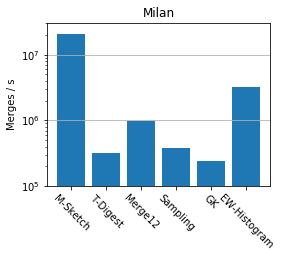

In [125]:
fig = plt.figure(figsize=(4,3))
ax = fig.gca()
gen_plot(dfm["n"]/(dfm["merge_time"]/1.0e9), ax)
ax.set_ylim(1e5, 3e7)
ax.set_ylabel("Merges / s")
ax.set_title("Milan")
fig.savefig("milan_e2e_throughput.pdf", bbox_inches='tight')

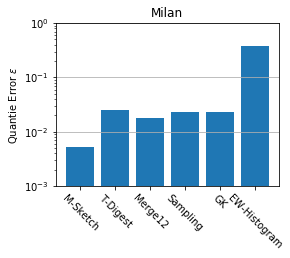

In [126]:
fig = plt.figure(figsize=(4,3))
ax = fig.gca()
gen_plot(dfm["error"], ax)
ax.set_ylim(1e-3, 1)
ax.set_ylabel("Quantie Error $\epsilon$")
ax.set_title("Milan")
fig.savefig("milan_e2e_error.pdf", bbox_inches='tight')

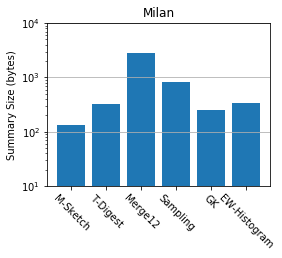

In [127]:
fig = plt.figure(figsize=(4,3))
ax = fig.gca()
gen_plot(dfm["space"], ax)
ax.set_ylim(10, 1e4)
ax.set_ylabel("Summary Size (bytes)")
ax.set_title("Milan")
fig.savefig("milan_e2e_size.pdf", bbox_inches='tight')

# Point Accuracy

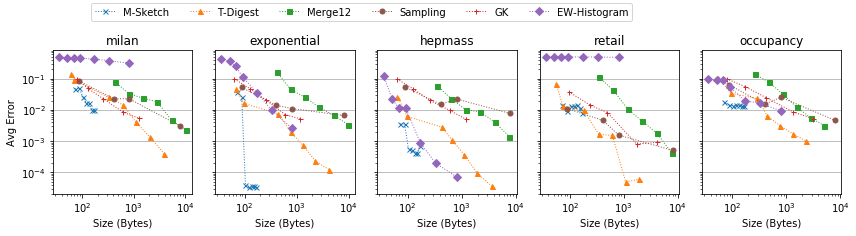

In [10]:
sketches = ["cmoments", "tdigest", "yahoo", "sampling", "spark_gk", "histogram"]
f, axs = plt.subplots(1,5, figsize=(12,3), sharey=True)
for di in range(len(datasets)):
    dname = datasets[di]
    ax = axs[di]
    df = point_results_processed[dname]
    lines = []
    labels = []
    for alg in sketches:
        c_df = df[df["sketch"] == alg]
        l, = ax.loglog(
            c_df["space"],
            c_df["error"], 
            label=alg_display_name[alg],
            marker=markers[alg],
            color=colormap[alg],
            markersize=5,
            ls="dotted",
            lw=1
        )
        lines.append(l)
        labels.append(alg_display_name[alg])

    ax.set_title(dname)
    ax.set_xlabel("Size (Bytes)")
    ax.yaxis.grid(True)
    if di == 0:
        ax.set_ylabel("Avg Error")

lgd = f.legend(
    lines, labels,
    bbox_to_anchor=(0.10, 1.00, 1., .102), ncol=6, loc=2
)
f.tight_layout()
f.savefig("point_accuracy.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

# Point Update

IndexError: index 2 is out of bounds for axis 0 with size 2

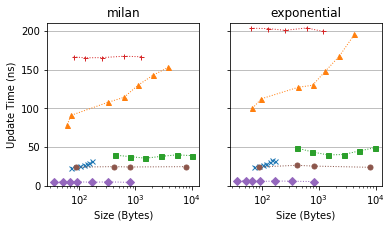

In [21]:
sketches = ["cmoments", "tdigest", "yahoo", "sampling", "spark_gk", "histogram"]
f, axs = plt.subplots(1,2, figsize=(6,3), sharey=True)
for di in range(len(datasets)):
    dname = datasets[di]
    ax = axs[di]
    df = point_results_processed[dname]
    lines = []
    labels = []
    for alg in sketches:
        c_df = df[df["sketch"] == alg]
        l, = ax.semilogx(
            c_df["space"],
            c_df["train_time"] / c_df["n"], 
            label=alg_display_name[alg],
            marker=markers[alg],
            color=colormap[alg],
            markersize=5,
            ls="dotted",
            lw=1
        )
        lines.append(l)
        labels.append(alg_display_name[alg])

    ax.set_title(dname)
    ax.set_ylim(0, 210)
    ax.set_xlabel("Size (Bytes)")
    ax.yaxis.grid(True)
    if di == 0:
        ax.set_ylabel("Update Time (ns)")

lgd = f.legend(
    lines, labels,
    bbox_to_anchor=(0.10, 1.05, 1., .102), ncol=4, loc=2
)
f.tight_layout()
f.savefig("point_update.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

# Point Solve Time

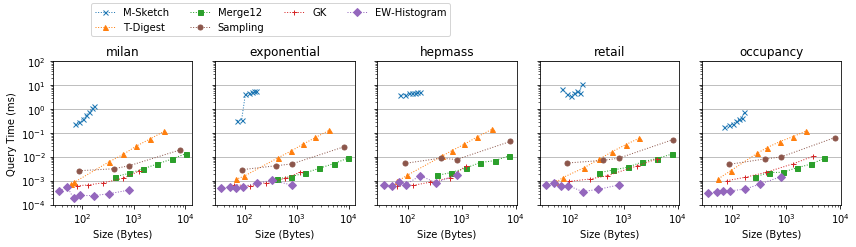

In [11]:
sketches = ["cmoments", "tdigest", "yahoo", "sampling", "spark_gk", "histogram"]
f, axs = plt.subplots(1,5, figsize=(12,3), sharey=True)
for di in range(len(datasets)):
    dname = datasets[di]
    ax = axs[di]
    df = point_results_processed[dname]
    lines = []
    labels = []
    for alg in sketches:
        c_df = df[df["sketch"] == alg]
        l, = ax.loglog(
            c_df["space"],
            c_df["query_time"] * 1e-6, 
            label=alg_display_name[alg],
            marker=markers[alg],
            color=colormap[alg],
            markersize=5,
            ls="dotted",
            lw=1
        )
        lines.append(l)
        labels.append(alg_display_name[alg])

    ax.set_title(dname)
    ax.set_ylim(1e-4, 100)
    ax.set_xlabel("Size (Bytes)")
    ax.yaxis.grid(True)
    if di == 0:
        ax.set_ylabel("Query Time (ms)")

lgd = f.legend(
    lines, labels,
    bbox_to_anchor=(0.10, 1.05, 1., .102), ncol=4, loc=2
)
f.tight_layout()
f.savefig("point_solve.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

# Point Bound Size

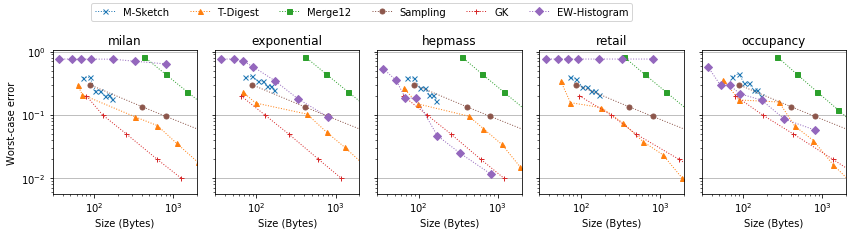

In [22]:
sketches = ["cmoments", "tdigest", "yahoo", "sampling", "spark_gk", "histogram"]
f, axs = plt.subplots(1,5, figsize=(12,3), sharey=True)
for di in range(len(datasets)):
    dname = datasets[di]
    ax = axs[di]
    df = point_results_processed[dname]
    lines = []
    labels = []
    for alg in sketches:
        c_df = df[df["sketch"] == alg]
        l, = ax.loglog(
            c_df["space"],
            c_df["bound_size"], 
            label=alg_display_name[alg],
            marker=markers[alg],
            color=colormap[alg],
            markersize=5,
            ls="dotted",
            lw=1
        )
        lines.append(l)
        labels.append(alg_display_name[alg])

    ax.set_title(dname)
    ax.set_xlim(30, 2000)
    ax.set_xlabel("Size (Bytes)")
    ax.yaxis.grid(True)
    if di == 0:
        ax.set_ylabel("Worst-case error")

lgd = f.legend(
    lines, labels,
    bbox_to_anchor=(0.10, 1.00, 1., .102), ncol=6, loc=2
)
f.tight_layout()
f.savefig("point_bound.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

# Merge Time

In [192]:
merge_results_processed["milan"].columns

Index(['sketch', 'size_param', 'q', 'quantile_estimate', 'train_time',
       'merge_time', 'bound_size', 'trial', 'space', 'query_time', 'n',
       'error', 'rerror'],
      dtype='object')

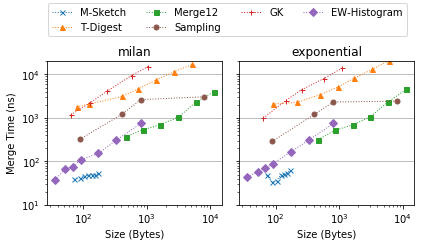

In [29]:
sketches = ["cmoments", "tdigest", "yahoo", "sampling", "spark_gk", "histogram"]
f, axs = plt.subplots(1,2, figsize=(6,3), sharey=True)
for di in range(len(m_datasets)):
    dname = m_datasets[di]
    ax = axs[di]
    df = merge_results_processed[dname]
    lines = []
    labels = []
    for alg in sketches:
        c_df = df[df["sketch"] == alg]
        l, = ax.loglog(
            c_df["space"],
            c_df["merge_time"] / c_df["n"], 
            label=alg_display_name[alg],
            marker=markers[alg],
            color=colormap[alg],
            markersize=5,
            ls="dotted",
            lw=1
        )
        lines.append(l)
        labels.append(alg_display_name[alg])

    ax.set_title(dname)
    ax.set_ylim(10, 2e4)
    ax.set_xlabel("Size (Bytes)")
    ax.yaxis.grid(True)
    if di == 0:
        ax.set_ylabel("Merge Time (ns)")

lgd = f.legend(
    lines, labels,
    bbox_to_anchor=(0.10, 1.05, 1., .102), ncol=4, loc=2
)
f.tight_layout()
f.savefig("merge_time.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')